In [1]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import shapely
import random
import numpy as np
from IPython.display import clear_output
import math
from mas_transportation_utils import *
#from mas_transportation_utils import all_paths
import rtree

%matplotlib inline
ox.config(log_console=True)
ox.__version__
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

ox.utils.config(bidirectional_network_types=['drive'])

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

### UNITES
1 TICK = 1 SECONDE

In [ ]:
gdf = ox.geocode_to_gdf('Piedmont, California, USA') 
# get the street network within this bounding box
west, south, east, north = list(gdf.bounds.iloc[0])
minx, miny, maxx, maxy = west, south, east, north
over_box = (minx, miny, maxx, maxy)
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
fig, ax = ox.plot_graph(G, figsize=(20, 20),  node_size=20)
# hwy_speeds = {'residential': 30,
#               'secondary': 50,
#               'tertiary': 70}
 hwy_speeds = {'residential': 50,
                      'primary':50,
                      'secondary':50,
                      'tertiary': 50,
                      'motorway': 50,
                      'trunk': 50}

G = ox.add_edge_speeds(G, hwy_speeds,  precision=0)
#temps arrondis
G = ox.add_edge_travel_times(G, precision=0)

In [ ]:
orig = list(G)[1]
dest = list(G)[400]
weight='length'
#weight='travel_time'
SP = ox.shortest_path(G,orig, dest, weight=weight)
SPt = 0
for i in range(len(SP)-1):
    node1 = SP[i]
    node2 = SP[i+1]
    SPt += G.get_edge_data(node1,node2)[0]['travel_time']
    
    
print("sptime", SPt)
#SP = list(nx.shortest_path(G, orig, dest, weight='length'))

y1 = G.nodes[orig]['y']
x1 = G.nodes[orig]['x']
y2 = G.nodes[dest]['y']
x2 = G.nodes[dest]['x']


In [ ]:
orig = list(G)[1]
dest = list(G)[400]
weight='travel_time'
SP = ox.shortest_path(G,orig, dest, weight=weight)
print("Spd=",compute_shortest_path_distance(G, SP),"m; Spt=",compute_shortest_path_time(G, SP),"s")

In [ ]:
G.get_edge_data(SP[0],SP[1])

In [ ]:
#Quelques test bbox

# def get_bbox_from_2_coords(y1,x1,y2,x2,coef=1):
#     if y1>y2 :
#         north = y1 + (1/2*ox.distance.euclidean_dist_vec(y1, x1, y2, x2)*coef)
#         south = y2 - (1/2*ox.distance.euclidean_dist_vec(y1, x1, y2, x2)*coef)
#     else :
#         north = y1 -(1/2*ox.distance.euclidean_dist_vec(y1, x1, y2, x2)*coef)
#         south = y2 + (1/2*ox.distance.euclidean_dist_vec(y1, x1, y2, x2)*coef)
        
#     if x1>x2:
#         east = x2  
#         west = x1
#     else :
#         east = x1 
#         west = x2
        
#     return(north,south,east,west)

# def get_bbox_2_0(y1,x1,y2,x2,coef=1):
#     if y1>y2 :
#         north = y1 + ((y1-y2)*coef)
#         south = y2 - ((y1-y2)*coef)
#     else :
#         north = y1 - ((y2-y1)*coef)
#         south = y2 + ((y2-y1)*coef)
        
#     if x1>x2:
#         east = x2 + ((x2-x1)*coef) 
#         west = x1 - ((x2-x1)*coef) 
#     else :
#         east = x1 + ((x1-x2)*coef)
#         west = x2 - ((x1-x2)*coef)
    
#     return(north,south,east,west)

# '''Ajouter pref ?'''
def get_bbox_min_max(G, SP, coef=0):
    min_lat = False
    max_lat = False
    min_lon = False
    max_lon = False
    for node in SP:
        lat = G.nodes[node]['y']
        lon = G.nodes[node]['x']
        if lat < min_lat or not min_lat :
            min_lat = lat
        if lat > max_lat or not max_lat:
            max_lat = lat
        if lon < min_lon or not min_lon:
            min_lon = lon
        if lon > max_lon or not max_lon :
            max_lon = lon
            
    min_lat = min_lat - ((max_lat-min_lat)*coef)
    max_lat = max_lat + ((max_lat-min_lat)*coef)
    
    min_lon = min_lon - ((max_lon-min_lon)*coef)
    max_lon = max_lon + ((max_lon-min_lon)*coef)
    return min_lat, min_lon, max_lat, max_lon

def get_bbox_idx(G, SP, slack_time, speed):
    min_lat = False
    max_lat = False
    min_lon = False
    max_lon = False
    for node in SP:
        lat = G.nodes[node]['y']
        lon = G.nodes[node]['x']
        if lat < min_lat or not min_lat :
            min_lat = lat
        if lat > max_lat or not max_lat:
            max_lat = lat
        if lon < min_lon or not min_lon:
            min_lon = lon
        if lon > max_lon or not max_lon :
            max_lon = lon
    
    if slack_time > 0:
        speed_mps = speed / 3.6
        meters = speed_mps * slack_time
        earth = 6378.137  #radius of the earth in kilometer
        pi = math.pi 
        m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree
        
        min_lat = min_lat - (meters*m)
        max_lat = max_lat + (meters*m)
        min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
        max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
        
        
        #min_lat = max(min_lat, sma.min_lat)
        #max_lat = min(max_lat, sma.max_lat)
    
        #min_lon = max(min_lon, sma.min_lon)
        #max_lon = min(max_lon, sma.max_lon)
    return min_lat, min_lon, max_lat, max_lon

In [ ]:
a = 10
b = a /3.6
c = 3 * b
print("kmh",a,"mps",b,"d",c,"m")

In [ ]:
#bbox1 = get_bbox_from_2_coords(y1,x1,y2,x2,coef=1)
#bbox2 = get_bbox_2_0(y1,x1,y2,x2,coef=1)
bbox3 = get_bbox_min_max(G, SP,0)
bbox4 = get_bbox_idx(G, SP, 30, 50)
#print("bbox1", bbox1, "\nbbox2", bbox2, "\nbbox3", bbox3 )
#idx.insert(1,bbox3,"bbox d1")

In [ ]:
bbox3

In [ ]:
bbox = bbox4
g_bbox = ox.truncate.truncate_graph_bbox(G, bbox[2], bbox[0], bbox[3], bbox[1], truncate_by_edge=True, retain_all=False)
#set(g_bbox.nodes)

In [ ]:
ox.plot_graph(G)
bbox = bbox3
print(bbox3)
g_bbox = ox.truncate.truncate_graph_bbox(G, bbox[2], bbox[0], bbox[3], bbox[1], truncate_by_edge=True, retain_all=False)
ox.plot_graph(g_bbox)
print('orig in bbox ?',orig in g_bbox)
print('dest in bbox ?',dest in g_bbox)
ox.plot_graph_route(g_bbox, ox.shortest_path(g_bbox, orig, dest), route_color='y', route_linewidth=6, node_size=0)
# #ox.plot_graph_route(G, ox.shortest_path(G, orig, dest), route_color='y', route_linewidth=6, node_size=6)
# #routes = list(ox.k_shortest_paths(g_bbox, orig, dest, 50))
# #ox.plot_graph_routes(g_bbox,routes)
bbox = bbox4
print(bbox4)
g_bbox = ox.truncate.truncate_graph_bbox(G, bbox[2], bbox[0], bbox[3], bbox[1], truncate_by_edge=False, retain_all=False)
ox.plot_graph(g_bbox)
print('orig in bbox ?',orig in g_bbox)
print('dest in bbox ?',dest in g_bbox)
ox.plot_graph_route(g_bbox, ox.shortest_path(g_bbox, orig, dest), route_color='y', route_linewidth=6, node_size=0)


In [2]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
    
    def update(self) -> None: 
        pass
    
    def decide(self) -> None:
        pass
    
class UserAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        
        #calcul de la longueur du plus court chemin à l'origine
        ###self.SPL = nx.shortest_path_length(sma.G, source=self.v_dep, target=self.v_arr)
        
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass    

In [7]:
class ContinuousDriverAgent(UserAgent):
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, capacity=3, detour_factor=0, pref_weight='travel_time', test=False):
        super().__init__(unique_id, v_dep, v_arr)
        
        self.dep_time = sma.tick
        
        self.pref_weight = pref_weight
        self.detour_factor = detour_factor
        self.SP = ox.shortest_path(sma.G, self.v_dep, self.v_arr, weight=pref_weight)
        self.SPt = compute_shortest_path_time(sma.G, self.SP)
        self.SPd = compute_shortest_path_distance(sma.G, self.SP)
        self.detour_factor = detour_factor
        
        self.trip = self.SP
        
        
        self.current_pos = dict()
        self.current_pos['node1'] = self.v_dep
        self.current_pos['node2'] = self.trip[1]
        self.current_pos['edge_data'] = sma.G.get_edge_data(self.v_dep, self.trip[1])[0]
        self.current_pos['time'] = 0
        
        self.total_distance=0
        #self.total_distance=self.current_pos['edge_data']['length']
        
        self.c = capacity
        self.l_arr_time = sma.tick + self.SPt + math.ceil(self.SPt*detour_factor) #'''arrondi ?'''
        self.v_r = self.trip[1]
        
        #tableaux du scheduling S
        self.arr = [sma.tick + self.current_pos['edge_data']['travel_time'], self.SPt] #tableau des premières arrivées
        self.ddl = [self.arr[0], self.l_arr_time] #tableau des dernières arrivées
        self.slk = [0, self.ddl[1]-self.arr[1]] #tableau de la marge de temps a chaque étape
        
        self.stops = [self.trip[1], v_arr] #tableau référençant les noeuds avec arrêts obligatoire 
                             #(noeuds de recup et de dépot des passagers et noeud d'arrivé du conducteur)
        self.capacities = [capacity, capacity]
        self.tag_event = False
        
        self.perceptions = [None] #les ellipses, la perception à chaque étape
        self.perceptions.append(self.get_perception_idx(self.v_r, self.v_arr, 1))
        sma.rtree.insert(self.unique_id, self.perceptions[1], (self.unique_id, 1))
        
        self.riders_distance = 0
        #affichage de la progression sur une carte
        self.test = test
        if self.test :
            fig, ax = ox.plot_graph_route(sma.G, self.trip, route_color='y', route_linewidth=6, node_size=0)

    
    def add_rider_to_scheduler(self, rider, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2):
        #on ajoute le passager au scheduler, on met a jour le trip et la capacité
        
        #########checks##############
        if dl_v1 > self.ddl[-1] or dl_v2 > self.ddl[-1]:
            raise Exception("Rider's deadline should be lower than driver's deadline")
            
        if r_v1 == r_v2:
            raise Exception("Driver",self.unique_id,"problème noeud égaux")

        if r_v2 in self.stops: #and (self.stops.index(r_v2) == idx2 or self.stops.index(r_v2) == 0):
            if self.ddl[self.stops.index(r_v2)] < dl_v2:
                self.ddl[self.stops.index(r_v2)] = dl_v2
        else :
            if idx1==idx2 and r_v1 in self.stops: #and self.stops.index(r_v1) == idx1:
                self.stops.insert(idx2+1, r_v2)
                self.ddl.insert(idx2+1, dl_v2)
                self.capacities.insert(idx2+1, self.capacities[idx2])
                                                     
            else:
                self.stops.insert(idx2, r_v2)
                self.ddl.insert(idx2, dl_v2)
                self.capacities.insert(idx2, self.capacities[idx2-1])
            
        if r_v1 in self.stops: #and (self.stops.index(r_v1) == idx1 or self.stops.index(r_v1) == 0):
            if self.ddl[self.stops.index(r_v1)] < dl_v1:
                self.ddl[self.stops.index(r_v1)] = dl_v1   
            
        else:
            self.stops.insert(idx1, r_v1)
            self.ddl.insert(idx1, dl_v1)
            self.capacities.insert(idx1, self.capacities[idx1-1])
            
        for i in np.arange(idx1,idx2):
            self.capacities[i]-=1        
        #puis on recalcule le chemin le plus court et la marge (skl = slack time)
        
        #pour le premier on se base sur le noeud courant
        self.arr = [self.arr[0]]
        dif = [self.ddl[0] - self.arr[0]]#normalement = à 0
        if self.ddl[0] - self.arr[0] < 0:
            raise Exception("Problème insertion conducteur",self.unique_id,"avec ddl",self.ddl[0],"et arr",self.arr[0],"premiere indice tableau/position courrante")
        
        #self.arr.append(sma.tick + (self.current_pos['edge_data']['travel_time'] - self.current_pos['time']) + compute_shortest_path_time(ox.shortest_path(sma.G, self.v_r, self.stops[0], weight=self.pref_weight)))
        #dif.append(self.ddl[0] - self.arr[0])
        
        
        for i in range(len(self.stops)-1):
            self.arr.append(self.arr[i] + compute_shortest_path_time(sma.G,ox.shortest_path(sma.G, self.stops[i], self.stops[i+1], weight=self.pref_weight)))
            dif.append(self.ddl[i+1] - self.arr[i+1])
        
        #calcul marge dépendante des marges suivantes
        self.slk = []
        for i in range(len(dif)):
            self.slk.append(np.min(dif[i:]))
        
#         if rider != None:
#             self.riders_distance+= rider.SPd
        self.tag_event = True
        self.update()
    
    def get_all_perceptions(self):
        perceptions = []
        perceptions.append(None)
            
        for i in range(len(self.stops)-1):
            if self.slk[i+1]==0:
                perceptions.append(None)
            else:
                perceptions.append(self.get_perception_idx(self.stops[i], self.stops[i+1], i+1))
    
        return perceptions
                                    
    def get_perception_idx(self, orig, dest, stop_idx):
        slack_time = self.slk[stop_idx]
        
        SP = ox.shortest_path(sma.G, orig, dest, weight=self.pref_weight)
        min_lat = False
        max_lat = False
        min_lon = False
        max_lon = False
        for node in SP:
            lat = sma.G.nodes[node]['y']
            lon = sma.G.nodes[node]['x']
            if lat < min_lat or not min_lat :
                min_lat = lat
            if lat > max_lat or not max_lat:
                max_lat = lat
            if lon < min_lon or not min_lon:
                min_lon = lon
            if lon > max_lon or not max_lon :
                max_lon = lon
                
        if slack_time > 0:
            speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
            meters = speed_mps * slack_time
            earth = 6378.137  #radius of the earth in kilometer
            pi = math.pi 
            m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


            min_lat = min_lat - (meters*m) 
            max_lat = max_lat + (meters*m) 
            min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
            max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
        
        #il ne faut pas dépasser les limites du graphe
        min_lat = max(min_lat, sma.min_lat)
        max_lat = min(max_lat, sma.max_lat)
    
        min_lon = max(min_lon, sma.min_lon)
        max_lon = min(max_lon, sma.max_lon)

        perception = (min_lon, min_lat, max_lon, max_lat)    
        
        return perception
        
        
    def update_perception(self):
        for p in self.perceptions:
            if p != None:
                sma.rtree.delete(self.unique_id, p)
        if self.is_alive:    
            new_perception=self.get_all_perceptions()
            for p in new_perception:
                if p != None:
                    sma.rtree.insert(self.unique_id, p, obj=(self.unique_id, new_perception.index(p)))

            self.perceptions = new_perception
        
                                    
        
                                    
    
#     def get_perception_set_node(self):
#         return set([item for sublist in self.perceptions for item in sublist])
    
#     def algo_recu_percep(self, current_node, visited, perception, max_weight):
#         for succ in G.neighbors(current_node):
#             if succ not in visited :
#                 visited.append(succ)
#                 try: 
#                     if nx.shortest_path_length(sma.G, orig, succ, weight=self.pref_weight) + nx.shortest_path_length(sma.G, succ, dest, weight=self.pref_weight) <= max_weight:
#                         perception.add(succ)
#                         self.algo_recu_percep(succ, visited, perception, max_weight)
#                 except (KeyError, nx.NetworkXNoPath):
#                     pass
            
    def update(self): 
        #a terme, il faudra identifier dans quelles ellipses sont les modifs et modif uniquement là
        if self.tag_event == True:
            self.update_perception()
            self.trip = ox.shortest_path(sma.G, self.v_r, self.stops[1], weight=self.pref_weight)
            self.tag_event = False
    
    def decide(self):
        current_time = self.current_pos['time'] + 1
        if current_time < self.current_pos['edge_data']['travel_time']:
            self.current_pos['time'] = current_time
            
        else :
            reste = current_time - self.current_pos['edge_data']['travel_time']
            self.current_pos = dict()
            self.current_pos['node1'] = self.trip.pop(0)
            self.current_pos['node2'] = self.trip[0]
            #print(self.current_pos['node1'], self.current_pos['node2'])
            #print(sma.G.get_edge_data(self.current_pos['node1'], self.current_pos['node2']))
            self.current_pos['edge_data'] = sma.G.get_edge_data(self.current_pos['node1'], self.current_pos['node2'])[0]
            self.current_pos['time'] = reste
            self.v_r = self.current_pos['node2']
            self.total_distance+=self.current_pos['edge_data']['length']
            
            if self.v_r == self.v_arr and self.stops[1]==self.v_arr:
                if self.test :
                    clear_output(wait=True)
                    fig, ax = ox.plot_graph_route(sma.G, [self.trip[-1]], route_color='y', route_linewidth=6, node_size=0)
                    
                self.is_alive = False
                self.update_perception()
                
                d_trip_time = sma.tick + self.current_pos['edge_data']['travel_time'] - self.current_pos['time'] - self.dep_time
                d_trip_length = self.total_distance
                sma.data['d_trip_time'].append(d_trip_time)
                sma.data['d_trip_length'].append(d_trip_length)
                sma.data['saved_distance']+=self.SPd-self.total_distance
                
                if sma.verbose == True:
                    print("Driver",self.unique_id,"arrived")
                
                
            else :
#                 if sma.verbose == True:
#                     print("Driver",self.unique_id,"passing through node",self.current_pos['node2'])
                if self.test :
                    clear_output(wait=True)
                    fig, ax = ox.plot_graph_route(sma.G, self.trip, route_color='y', route_linewidth=6, node_size=0)
                                                       
                                    
                #si le prochain noeud est un arret prévu                    
                if self.current_pos['node2'] == self.stops[1]:
                                    
                    self.arr.pop(0) 
                    self.slk.pop(1)
                    
                                    
                    self.ddl.pop(0)
                    self.ddl[0]=self.arr[0]
                    
                    self.capacities.pop(0)
                    
#                     if self.perceptions[1] != None:
#                         sma.rtree.delete(self.unique_id, self.perceptions[1])
#                     self.perceptions.pop(1)
                    
                    #print("d passe par un stop ?")
                                    
                    self.stops.pop(0)
                    self.update_perception()
                    
                    if self.current_pos['node2'] != self.v_arr:
                        self.trip = ox.shortest_path(sma.G, self.v_r, self.stops[1], weight=self.pref_weight)
                        
                    
                    
                else :
                    self.arr[0]+= self.current_pos['edge_data']['travel_time'] - self.current_pos['time']
                    self.ddl[0]=self.arr[0]
                    self.stops[0]=self.v_r
                    #self.trip = ox.shortest_path(sma.G, self.v_r, self.stops[1], weight=self.pref_weight)
                
                
                
                
                

In [4]:
class SMA:
    def __init__(self, verbose=False, verbose2=False, place='Piedmont, California, USA', speed=50, show_graph=False, hop='mhop'):
        self.tick=0 #1 tick = 1 seconde
        self.resetTicks()
        
        if hop in ['mhop','shop','nohop']:
            self.hop = hop
        else :
            raise Exception("hop parameters is either : mhop, shop or nohop")
            
        
        if place=='grid':
            north, south, east, west = 37.79, 37.78, -122.41, -122.43
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            
            
        else:
            gdf = ox.geocode_to_gdf(place) 
            # get the street network within this bounding box
            west, south, east, north = list(gdf.bounds.iloc[0])
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            #self.bbox = (self.min_lon, self.min_lat, self.max_lon, self.max_lat)
            
        self.G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
        
#         #filter deadends
#         deadends = []
#         for node in list(self.G.nodes):
#             if self.G.nodes[node]['street_count']==1:
#                 deadends.append(node)
#         print(deadends)
#         self.G.remove_nodes_from(deadends)
        
        if show_graph:
            fig, ax = ox.plot_graph(self.G, figsize=(20, 20),  node_size=20)
        self.speed = speed
        # hwy_speeds = {'residential': 30,
        #               'secondary': 50,
        #               'tertiary': 70}

        hwy_speeds = {'residential': self.speed,
                      'primary':self.speed,
                      'secondary': self.speed,
                      'tertiary': self.speed,
                      'motorway': self.speed,
                      'trunk': self.speed}

        self.G = ox.add_edge_speeds(self.G, hwy_speeds, fallback=50, precision=0)
        #temps arrondis
        self.G = ox.add_edge_travel_times(self.G, precision=0)
        
        #dictionnaire des agents par type
        self.agentTypeIdDict = {}
        self.agentTypeIdDict["drivers"] = []
        self.agentTypeIdDict["riders"] = []
        self.agentTypeIdDict["tsas"] = []
        self.agentTypeIdDict["tgas"] = []
        
        #dictionnaire des agents par id
        self.agentDict = {}
        
        #arbre d'indexation spatiale R-TREE
        self.rtree = rtree.index.Index()
        
        #self.G = None
        self.verbose = verbose
        self.verbose2 = verbose2
        
        
        ####DATA####
        self.data = dict()
        self.data['d_trip_time'] = []
        self.data['d_trip_length'] = []
        self.data['r_waiting_time'] = []
        self.data['r_nb_unmatched'] = 0
        self.data['mhop_count'] = 0
        self.data['shop_count'] = 0
        self.data['saved_distance'] = 0
    
    def resetTicks(self):
        self.tick=0
          
    def setRoadGraph(self,graph):
        self.G = graph
        
    def addAgent(self,ag):
        self.agentDict[ag.unique_id] = ag
        if "RiderAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["riders"].append(ag.unique_id)
        elif "DriverAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["drivers"].append(ag.unique_id)
        elif "TransportServiceAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tsas"].append(ag.unique_id)
        elif "TransportGeneratorAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tgas"].append(ag.unique_id)
        else: raise Exception(ag.__class__.__name__,"is a wrong type of agent.")
            
            
    def getAgentFromId(self, unique_id):
        return self.agentDict[unique_id]
    
    def getRiders(self):
        R = []
        for r in self.agentTypeIdDict['riders']:
            R.append(self.agentDict[r])
        return R
        
    def getDrivers(self):
        D = []
        for d in self.agentTypeIdDict['drivers']:
            D.append(self.agentDict[d])
        return D
        
    def getTSAs(self):
        TSA = []
        for tsa in self.agentTypeIdDict['tsas']:
            TSA.append(self.agentDict[tsa])
        return TSA
    
    def getTGAs(self):
        TGA = []
        for tga in self.agentTypeIdDict['tgas']:
            TGA.append(self.agentDict[tga])
        return TGA

    def run(self,rounds=None):
        if rounds==None:
            #on s'arrete si tout les passagers ou tout les conducteurs sont arrivés
            self.runOnce()
            while len([agent for agent in sma.agentDict.values() if ("RiderAgent" in agent.__class__.__name__)]) > 0 and len([agent for agent in sma.agentDict.values() if ("DriverAgent" in agent.__class__.__name__)]) > 0:
                self.runOnce()
            #print("Finished in",self.tick,"ticks")
        
        else :
            #génération classique
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentDict.values() :
            #print(ag.unique_id)
            ag.update()
            ag.decide()
        
        #phase de nettoyage des agents morts
        for ag in self.agentDict.copy().values():
            if ag.is_alive == False:
                if "RiderAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["riders"].remove(ag.unique_id)
                elif "DriverAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["drivers"].remove(ag.unique_id)
                elif "TransportServiceAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tsas"].remove(ag.unique_id)
                elif "TransportGeneratorAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tgas"].remove(ag.unique_id)
                else: raise Exception(ag.__class__.__name__,"is a wrong type of agent, even if diying.")
                
                self.agentDict.pop(ag.unique_id)
                
                
        if self.verbose == True:      
            print("tick",str(self.tick),"ended")

### Test 1: un conducteur va vers sa destination

In [ ]:
rounds = 500
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=True)
sma.addAgent(d1)
for _ in range(rounds):
    sma.runOnce()
    #print(sma.rtree)
    #print(list(sma.rtree.intersection(d1.perceptions[1],objects='raw')))

### Test 2: un conducteur prends en charge une requete fictive (aucun test de faisabilité)

In [ ]:
rounds = 1000
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=True)
sma.addAgent(d1)
for _ in range(30):
    sma.runOnce()

p_cs = d1.perceptions[1]
p_node_cs = set(ox.truncate.truncate_graph_bbox(G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
r1, r2 = random.sample(p_node_cs,2)
d1.add_rider_to_scheduler(None, r1, r2, 60, 100, 1, 1)

for _ in range(1000):
    sma.runOnce()

In [21]:
class RiderAgent(UserAgent):
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, detour_factor=0, waiting_time=5, pref_weight='travel_time'):
        super().__init__(unique_id, v_dep, v_arr)
        self.max_wt = waiting_time * 60 #minutes vers secondes
        self.v_dep = v_dep
        self.v_arr = v_arr
        self.pref_weight = pref_weight
        self.detour_factor = detour_factor
        self.SP = ox.shortest_path(sma.G, self.v_dep, self.v_arr, weight=pref_weight)
        self.SPt = compute_shortest_path_time(sma.G, self.SP)
        self.SPd = compute_shortest_path_distance(sma.G, self.SP)
        self.detour_factor = detour_factor
        self.arr = sma.tick + self.SPt
        self.l_arr_time = sma.tick + self.max_wt + self.SPt + math.ceil(self.SPt*detour_factor) #'''arrondi ?'''
        self.l_dep_time = sma.tick + self.max_wt
        self.perception = None #les ellipses, la perception à chaque étape
#         self.wt_perception = None
        self.wt = 0
        self.checked_couples = set() #on stock les couples de conducteurs déja vérifiés
        self.checked_drivers = set()
        self.v_dep_lat = sma.G.nodes[self.v_dep]['y']
        self.v_dep_lon = sma.G.nodes[self.v_dep]['x']
        self.v_arr_lat = sma.G.nodes[self.v_arr]['y']
        self.v_arr_lon = sma.G.nodes[self.v_arr]['x']
        
        
        self.served = False
    
    def get_perception_trip(self):
        slack_time = self.l_arr_time - self.arr - self.wt
        # ou 
        #slack_time = self.l_arr_time - self.max_wt #le wt n'est pas vraiment du détour ?
        
        SP = ox.shortest_path(sma.G, self.v_dep, self.v_arr, weight=self.pref_weight)
        min_lat = False
        max_lat = False
        min_lon = False
        max_lon = False
        for node in SP:
            lat = sma.G.nodes[node]['y']
            lon = sma.G.nodes[node]['x']
            if lat < min_lat or not min_lat :
                min_lat = lat
            if lat > max_lat or not max_lat:
                max_lat = lat
            if lon < min_lon or not min_lon:
                min_lon = lon
            if lon > max_lon or not max_lon :
                max_lon = lon
                
        if slack_time > 0:
            speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
            meters = speed_mps * slack_time
            earth = 6378.137  #radius of the earth in kilometer
            pi = math.pi 
            m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


            min_lat = min_lat - (meters*m) 
            max_lat = max_lat + (meters*m) 
            min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
            max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
            
        #il ne faut pas dépasser les limites du graphe
        min_lat = max(min_lat, sma.min_lat)
        max_lat = min(max_lat, sma.max_lat)
    
        min_lon = max(min_lon, sma.min_lon)
        max_lon = min(max_lon, sma.max_lon)

        perception = (min_lon, min_lat, max_lon, max_lat)    
        
        return perception
        
#     def get_perception_wt(self):
        
#         min_lat, max_lat = self.lat
#         min_lon, max_lon = self.lon
        
#         slack_time = self.wt
#         if slack_time > 0:
#             speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
#             meters = speed_mps * slack_time
#             earth = 6378.137  #radius of the earth in kilometer
#             pi = math.pi 
#             m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


#             min_lat = min_lat - (meters*m) 
#             max_lat = max_lat + (meters*m) 
#             min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
#             max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
        
#         #il ne faut pas dépasser les limites du graphe
#         min_lat = max(min_lat, sma.min_lat)
#         max_lat = min(max_lat, sma.max_lat)
    
#         min_lon = max(min_lon, sma.min_lon)
#         max_lon = min(max_lon, sma.max_lon)

#         perception = (min_lat, min_lon, max_lat, max_lon)    
        
#         return perception
        
    
        
        
        
    def update(self):
        if not self.served:
#             if sma.verbose:
#                 print("Rider",self.unique_id,"looking for a ride")
            self.perception = self.get_perception_trip()
            #self.wt_perception = self.get_perception_wt()

            #phase candidats approché
            #set conducteur avec le noeud de départ dans leur perception
            Q1 = list(sma.rtree.intersection((self.v_dep_lon,self.v_dep_lat,self.v_dep_lon,self.v_dep_lat),objects="raw"))
            #print(Q1)
            
            #si aucun, on ne pourra pas bouger de toute façon
            if not Q1 :
                return
            
            #set conducteur dont perception dans la zone d'attente
            #d_on_wt = sma.rtree.intersection((self.wt_perception),objects="raw")
            
            #set conducteur dont perception est dans perception passager
            Q2 = list(sma.rtree.intersection((self.perception),objects="raw"))
            #print(Q2)
            if not Q2 :
                return
            #set conducteur dont noeud d'arrivé est dans perception
            Q3 = list(sma.rtree.intersection((self.v_arr_lon,self.v_arr_lat,self.v_arr_lon,self.v_arr_lat),objects="raw"))
            #print(Q3)
            if not Q3 :
                return
            

            
            candidates_s = set()
            cur_d_s = set()
            for d1_id, idx1 in Q1:
                for d2_id, idx2 in Q2:
                    if d1_id == d2_id and idx1 <= idx2:
                        d1 = sma.getAgentFromId(d1_id)
                        candidates_s.add((d1,idx1,idx2))
                        cur_d_s.add(d1_id)
                              
            
            candidates_e = set()
            cur_d_e = set()
            for d2_id, idx2 in Q2:
                for d3_id, idx3 in Q3:
                    if d2_id == d3_id and idx2 <= idx3:
                        d2 = sma.getAgentFromId(d2_id)
                        candidates_e.add((d2,idx2,idx3))
                        cur_d_e.add(d2_id)
                        
            if len(cur_d_s - self.checked_drivers) == 0 and len(cur_d_e - self.checked_drivers) == 0:
                return
#             if sma.verbose:
#                 print("checking riders at start id:",[cand[0].unique_id for cand in candidates_s])   
#                 print("checking riders at end id:",[cand[0].unique_id for cand in candidates_e])   

            best_candidate = None
            p_node_r = set(ox.truncate.truncate_graph_bbox(sma.G, self.perception[3], self.perception[1], self.perception[2], self.perception[0], truncate_by_edge=False, retain_all=False).nodes)
            wt_transfert = 0
            for cand_s in candidates_s:
                self.checked_drivers.add(cand_s[0].unique_id)
#                 if sma.verbose:
#                     print(cand_s[0].unique_id)
#                     print(cand_s[0].perceptions)
#                     print(cand_s[2])
                p_cs = cand_s[0].perceptions[cand_s[2]]
                if p_cs[3]==p_cs[1] or p_cs[2]==p_cs[0]:
                    print("oof")
                    continue
                p_node_cs = set(ox.truncate.truncate_graph_bbox(sma.G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
                Spt_ds_v1 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_s[0].stops[cand_s[1]-1], self.v_dep, weight=cand_s[0].pref_weight))
                    
                #si le candidat au départ respecte le temps d'attente du passager et qu'il a de la place   
                if Spt_ds_v1 + cand_s[0].arr[cand_s[1]-1] <= self.l_dep_time and cand_s[0].capacities[cand_s[1]-1]>0:  
                    #print("time check ok")
                    for cand_e in candidates_e:
                        
                        self.checked_drivers.add(cand_e[0].unique_id)
                        if (cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]) in self.checked_couples:
                            #print("coucou")
                            continue
                        #print("coucou2")
                        self.checked_couples.add((cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]))
                        
                        
                        #single hop ?
                        if cand_s[0].unique_id == cand_e[0].unique_id:
                            
                            #print("single hop ok")
                            #dans la meme bbox de perception?
                            if cand_s[1] == cand_e[2]:
                                #print("meme perception ok")
                                Spt_ds_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_dep, self.v_arr, weight=cand_s[0].pref_weight))
                                Spt_ds_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_s[0].stops[cand_s[1]], weight=cand_s[0].pref_weight))
                                
                                fitness = Spt_ds_v1 + Spt_ds_v2 + cand_s[0].arr[cand_s[1]-1]
                                if (fitness <= self.l_arr_time) and (fitness+Spt_ds_v3 - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]]) and cand_s[0].capacities[cand_s[1]-1]>0:
                                    #print("grosse contrainte ok")
                                    
                                    if best_candidate == None or best_candidate[2]>=fitness:
                                        d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_s[1]) #r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                        d2_data = None
                                        if sma.verbose2:
                                            print("best_candidate was",best_candidate)
                                        best_candidate=(d1_data, d2_data, fitness) 
                                        if sma.verbose2:
                                            print("best_candidate is",best_candidate)



                            else:
                                #redondance avec plus bas
                                Spt_ds_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_dep, cand_s[0].stops[cand_s[1]], weight=cand_s[0].pref_weight))
                                Spt_ds_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_s[0].stops[cand_e[2]-1],self.v_arr, weight=cand_s[0].pref_weight))
                                Spt_ds_v4 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_s[0].stops[cand_e[2]], weight=cand_s[0].pref_weight))
                                #condition au départ
                                new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :
                                    fitness = cand_s[0].arr[cand_e[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3
                                    #condition a l'arrivée
                                    if (fitness+Spt_ds_v4-cand_s[0].arr[cand_e[2]]<=cand_s[0].slk[cand_e[2]]) and\
                                    (fitness <= self.l_arr_time) and\
                                    all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_e[2]]):
                                        if best_candidate == None or best_candidate[2]>=fitness:
                                            d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_e[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                            d2_data = None
                                        
                                            if sma.verbose2:
                                                print("best_candidate was",best_candidate)
                                            best_candidate=(d1_data, d2_data, fitness) 
                                            if sma.verbose2:
                                                print("best_candidate is",best_candidate)
                                            
                        #multihop?                    
                        else:
                            if sma.hop != 'mhop':
                                continue
                            p_ce = cand_e[0].perceptions[cand_e[1]]
#                             if p_ce[3]==p_ce[1] or p_ce[2]==p_ce[0]:
#                                 continue
                            p_node_ce = set(ox.truncate.truncate_graph_bbox(sma.G, p_ce[3], p_ce[1], p_ce[2], p_ce[0], truncate_by_edge=False, retain_all=False).nodes)
                            transfert_nodes = p_node_r.intersection(p_node_cs, p_node_ce)
                            
                                
                            for t_node in transfert_nodes:
                                if cand_s[1] == cand_s[2]:
                                    #print(self.v_dep, t_node)
                                    Spt_ds_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_dep, t_node, weight=cand_s[0].pref_weight))
                                    arr_cs_t_node = cand_s[0].arr[cand_s[1]-1] +Spt_ds_v1 + Spt_ds_v2
                                    Spt_de_v1 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_e[0].stops[cand_e[1]-1], t_node, weight=cand_e[0].pref_weight))
                                    arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 
                                    #si le premier conducteur arrive avant le second
                                    if arr_cs_t_node <= arr_ce_t_node:
                                        wt_transfert = arr_ce_t_node - arr_cs_t_node 
                                        Spt_ds_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, cand_s[0].stops[cand_s[1]], weight=cand_s[0].pref_weight))
                                        if arr_cs_t_node+Spt_ds_v3-cand_s[0].arr[cand_s[1]] <=cand_s[0].slk[cand_s[1]] and cand_s[0].capacities[cand_s[1]-1]>0:
                                            if cand_e[1] == cand_e[2]:
                                                Spt_de_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, self.v_arr, weight=cand_e[0].pref_weight))
                                                Spt_de_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_e[0].stops[cand_e[1]], weight=cand_e[0].pref_weight))
                                                if arr_ce_t_node+Spt_de_v2+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                    #fitness = arr_cs_t_node + wt_transfert + Spt_de_v2
                                                    fitness =  arr_ce_t_node + Spt_de_v2
                                                    
                                                    if fitness <= self.l_arr_time:
                                                        if best_candidate == None or best_candidate[2]>fitness:
                                                            d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                            d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                                            if sma.verbose2:
                                                                print("best_candidate was",best_candidate)
                                                            best_candidate=(d1_data, d2_data, fitness) 
                                                            if sma.verbose2:
                                                                print("best_candidate is",best_candidate)
          
                                            else: 
                                                #redondance avec plus haut
                                                Spt_de_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, cand_e[0].stops[cand_e[1]], weight=cand_e[0].pref_weight))
                                                
                                                 #condition au départ
                                                new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                    #condition a l'arrivée
                                                    Spt_de_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_e[0].stops[cand_e[2]-1], self.v_arr, weight=cand_e[0].pref_weight))
                                                    Spt_de_v4 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_e[0].stops[cand_e[2]], weight=cand_e[0].pref_weight))
                                                    fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3
                                                    
                                                    if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and (fitness <= self.l_arr_time) and\
                                                    all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                
                                                        if best_candidate == None or best_candidate[2]>fitness:
                                                            d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                            d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                        
                                                            if sma.verbose2:
                                                                print("best_candidate was",best_candidate)
                                                            best_candidate=(d1_data, d2_data, fitness) 
                                                            if sma.verbose2:
                                                                print("best_candidate is",best_candidate)
                                                               
                                else:
                                    Spt_ds_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_dep, cand_s[0].stops[cand_s[1]], weight=cand_s[0].pref_weight))
                                    new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                    if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :
                                        
                                        Spt_ds_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_s[0].stops[cand_s[2]-1], t_node, weight=cand_e[0].pref_weight))
                                        arr_cs_t_node = cand_s[0].arr[cand_s[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3
                                        
                                        Spt_de_v1 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_e[0].stops[cand_e[1]-1], t_node, weight=cand_e[0].pref_weight))
                                        arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 
                                        
                                        #si le premier conducteur arrive avant le second
                                        if arr_cs_t_node <= arr_ce_t_node:
                                            wt_transfert =  arr_ce_t_node - arr_cs_t_node
                                            #j'ai modif ici cand_s[0].stops[cand_s[2]] 2 a la place de 1
                                            Spt_ds_v4 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, cand_s[0].stops[cand_s[2]], weight=cand_s[0].pref_weight))
                                            if arr_cs_t_node + Spt_ds_v4 - cand_s[0].arr[cand_s[2]] <= cand_s[0].slk[cand_s[2]] and all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_s[2]]):
                                                #redondance avec plus haut
                                                if cand_e[1] == cand_e[2]:
                                                    Spt_de_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, self.v_arr, weight=cand_e[0].pref_weight))
                                                    Spt_de_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_e[0].stops[cand_e[1]], weight=cand_e[0].pref_weight))
                                                    fitness = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                    if fitness+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                        if fitness <= self.l_arr_time:
                                                            
                                                            if best_candidate == None or best_candidate[2]>fitness:
                                                                d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                        
                                                                if sma.verbose2:
                                                                    print("best_candidate was",best_candidate)
                                                                best_candidate=(d1_data, d2_data, fitness) 
                                                                if sma.verbose2:
                                                                    print("best_candidate is",best_candidate)
                                                else: 
                                                    Spt_de_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, cand_e[0].stops[cand_e[1]], weight=cand_e[0].pref_weight))

                                                    #condition au départ
                                                    new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                    if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                        Spt_de_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_e[0].stops[cand_e[2]-1], self.v_arr, weight=cand_e[0].pref_weight))
                                                        Spt_de_v4 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_e[0].stops[cand_e[2]], weight=cand_e[0].pref_weight))
                                                        fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3
                                        
                                                        if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and\
                                                        (fitness <= self.l_arr_time) and\
                                                        all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                            
                                                            if best_candidate == None or best_candidate[2]>fitness:
                                                                d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                        
                                                                if sma.verbose2:
                                                                    print("best_candidate was",best_candidate)
                                                                best_candidate=(d1_data, d2_data, fitness) 
                                                                if sma.verbose2:
                                                                    print("best_candidate is",best_candidate) 
                                                    
                
           
                
                        
                    
            if(best_candidate != None):
                #pass bug
                if best_candidate[0][1] == best_candidate[0][2]:
                    print(best_candidate)
                    best_candidate=(best_candidate[1],None,best_candidate[2])
                  
                d1 = best_candidate[0][0]
                data1 = best_candidate[0][1:]
                sma.getAgentFromId(d1.unique_id).add_rider_to_scheduler(self, data1[0], data1[1], data1[2], data1[3], data1[4], data1[5])
                sma.getAgentFromId(d1.unique_id).perceptions
                #check singlehop
                if best_candidate[1] != None:
                    d2 = best_candidate[1][0]
                    data2 = best_candidate[1][1:]
                    sma.getAgentFromId(d2.unique_id).add_rider_to_scheduler(self, data2[0], data2[1], data2[2], data2[3], data2[4], data2[5])
                    if sma.verbose:
                        print("Rider",self.unique_id,"multihop with",d1.unique_id,"and",d2.unique_id)
                    sma.data['mhop_count']+=1
                else:
                    if sma.verbose:
                        
                        print("Rider",self.unique_id,"single hop with",d1.unique_id)
                    sma.data['shop_count']+=1
                    
                total_wt = self.wt + data1[2] - sma.tick + wt_transfert
                sma.data['r_waiting_time'].append(abs(total_wt))
                sma.data['saved_distance']+=self.SPd
                self.served = True
               
                    
                #ajoute meilleurs candidats
                #notifier conducteur pour ajouter passager
            
        
    
    def decide(self):
        if not self.served:
            self.wt+= 1
            if self.wt==self.max_wt:
                self.is_alive = False
                if sma.verbose:
                    print("Rider",self.unique_id,"cancels.")
                sma.data['r_nb_unmatched'] += 1
        else :
            self.is_alive = False
#             if sma.verbose:
#                 print("Rider",self.unique_id,"found a trip.")
            
            
        
        
        

In [ ]:
a = ((1,1,3),(2,3,5),6)
if a[0][0] == a[0][1]:
    a = (a[1],None,a[2])
a

In [ ]:
a = {1,2,3,6,7,9}
b = {1,2,3}

len(b-a)

### TEST 4 : ajout d'un vrai conducteur à un passager (sans verif faisabilité)

In [ ]:
rounds = 1000
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=5, pref_weight='travel_time',test=True)
sma.addAgent(d1)
for _ in range(30):
    sma.runOnce()
p_cs = d1.perceptions[1]
p_node_cs = set(ox.truncate.truncate_graph_bbox(G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
v1, v2 = random.sample(p_node_cs,2)
r1 = RiderAgent(3, v1, v2, detour_factor=10, waiting_time=25, pref_weight='travel_time')
sma.addAgent(r1)
for _ in range(1000):
    sma.runOnce()
    #print(d1.stops)

In [ ]:
sma.data

### TEST 5 : Plusieurs conducteurs avec plusieurs passager, test avec contraintes et verif faisabilité, MHOP

In [ ]:
NB_RUN = 300
MAX_NB_DRIVERS = 10
MAX_NB_RIDERS = 10
DET_FACTOR_D = 0.25
DET_FACTOR_R = 0.5
WT = 4
#sma = SMA(place='Lille, France')
sma = SMA(place='grid', show_graph=True, verbose=True, verbose2=True, hop='mhop')
G = sma.G
count_id = 1
for i in range(MAX_NB_DRIVERS):
    v1, v2 = random.sample(list(sma.G.nodes),2)
    while not nx.has_path(sma.G, v1, v2):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        
    d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
    sma.addAgent(d)
    count_id+=1
    
for i in range(MAX_NB_RIDERS):
    v1, v2 = random.sample(list(sma.G.nodes),2)
    while not nx.has_path(sma.G, v1, v2):
        v1, v2 = random.sample(list(sma.G.nodes),2)
    r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT, pref_weight='travel_time')
    sma.addAgent(r)
    count_id+=1

for _ in range(NB_RUN):
    print("tick:",sma.tick)
    sma.runOnce()

In [ ]:
sma.data

In [ ]:
sma.data

In [ ]:
20*(50/3.6)

- 1 tick = 1 secondes
- temps : secondes dnas le système, temps d'attente en minutes
- distances : metres
- vitesse : km/h, converti pour les calculs en m/s

### XP1 : Effet du détour conducteur

In [ ]:
# TIME_LIMIT = 1000 #secondes
# SEED = 12

# NB_RIDERS = 250
# RIDER_FREQUENCY = NB_RIDERS/TIME_LIMIT #nombre de passagers par secondes
# DET_FACTOR_R = 0.2
# WT_R = 5

# NB_DRIVERS = 250
# DRIVER_FREQUENCY = NB_DRIVERS/TIME_LIMIT #nombre de conducteurs par secondes
# DET_FACTOR_D = [0.2,0.4,0.6,0.8,1]

# HOP = ['mhop','shop']
# #SEED = [1,6,42,69,48,100,26,35,89,663,559,478,452,236,5789,555,666,777,888,999,111,222,333,444,555]
# SEED = [1,6,42,69]
# #creation conducteurs et passagers



# for det_d in DET_FACTOR_D:
#         #creation conducteurs
#     for seed in SEED:
#         random.seed(SEED)

#         riders = []
#         for i in range(NB_RIDERS):
#             v1, v2 = random.sample(list(sma.G.nodes),2)
#             while not nx.has_path(sma.G, v1, v2):
#                 v1, v2 = random.sample(list(sma.G.nodes),2)
#             r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT, pref_weight='travel_time')
#             riders.append(r)
#             count_id+=1


#         drivers = []
#         for i in range(NB_DRIVERS):
#             v1, v2 = random.sample(list(sma.G.nodes),2)
#             while not nx.has_path(sma.G, v1, v2):
#                 v1, v2 = random.sample(list(sma.G.nodes),2)

#             d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
#             drivers.append(d)
#             count_id+=1



#         for hop in HOP:
#             sma = SMA(place='grid', show_graph=True, verbose=True, hop='mhop')
#             #on ajoute 10% des utilisateurs au départ
#             for _ in range(int(NB_DRIVERS/10)):
#                 sma.addAgent(drivers.pop())
#             for _ in range(int(NB_RIDERS/10)):
#                 sma.addAgent(riders.pop())    
#             driver_frequency = 0
#             riders_frequency = 0

#             for _ in range(TIME_LIMIT):
#                 print("tick:",sma.tick)

#                 driver_frequency+=DRIVER_FREQUENCY
#                 while driver_frequency>=1 and len(drivers)>0:
#                     sma.addAgent(drivers.pop())
#                     driver_frequency-=1

#                 riders_frequency+=RIDER_FREQUENCY
#                 while riders_frequency>=1 and len(riders)>0:
#                     sma.addAgent(riders.pop())
#                     driver_frequency-=1

#                 sma.runOnce()


In [ ]:
TIME_LIMIT = 500 #secondes

NB_RIDERS = 75
WT_R = 3
RIDER_FREQUENCY = NB_RIDERS/(TIME_LIMIT-(WT_R*60)) #nombre de passagers par secondes
print("Frequence d'apparition passager:",RIDER_FREQUENCY,"par secondes.")
DET_FACTOR_R = 0.5


NB_DRIVERS = 100
DRIVER_FREQUENCY = NB_DRIVERS/(TIME_LIMIT-(WT_R*60)) #nombre de conducteurs par secondes
print("Frequence d'apparition conducteurs:",DRIVER_FREQUENCY,"par secondes.")
DET_FACTOR_D = [1,0.75,0.5,0.25]
#DET_FACTOR_D = [0.5,0.25]
#DET_FACTOR_D = [0.1,0.2]
HOP = ['mhop','shop']
#SEED = [1,6,42,69,48,100,26,35,89,663,559,478,452,236,5789,555,666,777,888,999,111,222,333,444,555]
SEED = [1,42,36]
#SEED = [3,6]

# TIME_LIMIT = 1000 #secondes

# NB_RIDERS = 30
# RIDER_FREQUENCY = NB_RIDERS/TIME_LIMIT #nombre de passagers par secondes
# DET_FACTOR_R = 0.2
# WT_R = 5

# NB_DRIVERS = 30
# DRIVER_FREQUENCY = NB_DRIVERS/TIME_LIMIT #nombre de conducteurs par secondes
# #DET_FACTOR_D = [0.2,0.4,0.6,0.8,1]
# DET_FACTOR_D = [0.4,0.6]
# HOP = ['mhop','shop']
# #SEED = [1,6,42,69,48,100,26,35,89,663,559,478,452,236,5789,555,666,777,888,999,111,222,333,444,555]
# #SEED = [1,6,42,69]
# SEED = [3,6]


results = []

for hop in HOP:
    
    mean_nb_unmatched = []
    mean_waiting_time = []
    mean_trip_length = []
    mean_trip_time = []
    mean_nb_shop = []
    mean_nb_mhop = []
    mean_saved_distance = []
    
        
    for det_d in DET_FACTOR_D:
        local_mean_nb_unmatched = []
        local_mean_waiting_time = []
        local_mean_trip_length = []
        local_mean_trip_time = []
        local_mean_nb_shop = []
        local_mean_nb_mhop = []
        local_mean_saved_distance = []
        
        for seed in SEED:
            random.seed(seed)
            count_id = 0
            sma = SMA(place='grid', show_graph=False, verbose=True, hop=hop)

            riders_nodes = []
            for _ in range(NB_RIDERS):
                v1, v2 = random.sample(list(sma.G.nodes),2)
                while not nx.has_path(sma.G, v1, v2):
                    v1, v2 = random.sample(list(sma.G.nodes),2)
                riders_nodes.append((v1, v2))


            drivers_nodes = []
            for _ in range(NB_DRIVERS):
                v1, v2 = random.sample(list(sma.G.nodes),2)
                while not nx.has_path(sma.G, v1, v2):
                    v1, v2 = random.sample(list(sma.G.nodes),2)
                drivers_nodes.append((v1,v2))
               
        
            #on ajoute 10% des utilisateurs au départ
            for _ in range(int(NB_DRIVERS/10)):
                v1, v2 = drivers_nodes.pop()
                d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
                sma.addAgent(d)
                count_id+=1
                
            for _ in range(int(NB_RIDERS/10)):
                v1, v2 = riders_nodes.pop()
                r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
                sma.addAgent(r)
                count_id+=1  
                
                
                
            drivers_frequency = 0
            riders_frequency = 0

            for _ in range(TIME_LIMIT):
                if sma.tick%int(TIME_LIMIT/10)==0:
                    print("tick:",sma.tick)

                drivers_frequency+=DRIVER_FREQUENCY
                while drivers_frequency>=1 and len(drivers_nodes)>0:
                    v1, v2 = drivers_nodes.pop()
                    d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
                    sma.addAgent(d)
                    #print("new_d")
                    count_id+=1
                    drivers_frequency-=1

                riders_frequency+=RIDER_FREQUENCY
                
    
                while riders_frequency>=1 and len(riders_nodes)>0:
                    v1, v2 = riders_nodes.pop()
                    r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
                    sma.addAgent(r)
                    #print("new_r")
                    count_id+=1  
                    riders_frequency-=1
                
                sma.runOnce()
                
            #on récupère les données
            local_mean_trip_time.append(np.mean(sma.data['d_trip_time']))
            print(local_mean_trip_time)
            local_mean_waiting_time.append(np.mean(sma.data['r_waiting_time']))
            print(local_mean_waiting_time)
            local_mean_trip_length.append(np.mean(sma.data['d_trip_length']))
            print(local_mean_trip_length)
            local_mean_nb_unmatched.append(sma.data['r_nb_unmatched'])
            print(local_mean_nb_unmatched)
            local_mean_nb_shop.append(sma.data['shop_count'])
            print(local_mean_nb_shop)
            local_mean_nb_mhop.append(sma.data['mhop_count'])
            print(local_mean_nb_mhop)
            local_mean_saved_distance.append(sma.data['saved_distance'])
            print(local_mean_saved_distance)
            

        mean_trip_time.append((np.mean(local_mean_trip_time),np.std(local_mean_trip_time)))
        mean_waiting_time.append((np.mean(local_mean_waiting_time),np.std(local_mean_waiting_time)))
        mean_trip_length.append((np.mean(local_mean_trip_length),np.std(local_mean_trip_length)))
        mean_nb_unmatched.append((np.mean(local_mean_nb_unmatched),np.std(local_mean_nb_unmatched)))
        mean_nb_shop.append((np.mean(local_mean_nb_shop),np.std(local_mean_nb_shop)))
        mean_nb_mhop.append((np.mean(local_mean_nb_mhop),np.std(local_mean_nb_mhop)))
        mean_saved_distance.append((np.mean(local_mean_saved_distance),np.std(local_mean_saved_distance)))
        print(hop, det_d, "finished.")  
            
    results.append([mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance, mean_nb_shop, mean_nb_mhop])

In [ ]:
results

### XP minimale

In [ ]:
TIME_LIMIT = 500 #secondes

NB_RIDERS = 10
WT_R = 3
DET_FACTOR_R = 0.2


NB_DRIVERS = 15
DET_FACTOR_D = [0.25,0.5,0.75,1]
#DET_FACTOR_D = [0.1,0.2]
HOP = ['mhop','shop']
#SEED = [1,6,42,69,48,100,26,35,89,663,559,478,452,236,5789,555,666,777,888,999,111,222,333,444,555]
SEED = [1,42,58,96,35,64,72]

results = []

for hop in HOP:
    
    mean_nb_unmatched = []
    mean_waiting_time = []
    mean_trip_length = []
    mean_trip_time = []
    mean_nb_shop = []
    mean_nb_mhop = []
    mean_saved_distance = []
    
        
    for det_d in DET_FACTOR_D:
        local_mean_nb_unmatched = []
        local_mean_waiting_time = []
        local_mean_trip_length = []
        local_mean_trip_time = []
        local_mean_nb_shop = []
        local_mean_nb_mhop = []
        local_mean_saved_distance = []
        
        for seed in SEED:
            random.seed(seed)
            count_id = 0
            sma = SMA(place='grid',show_graph=False, verbose=True, hop=hop)

           
            for i in range(NB_RIDERS):
                v1, v2 = random.sample(list(sma.G.nodes),2)
                while not nx.has_path(sma.G, v1, v2):
                    v1, v2 = random.sample(list(sma.G.nodes),2)
                r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
                sma.addAgent(r)
                count_id+=1



            for i in range(NB_DRIVERS):
                v1, v2 = random.sample(list(sma.G.nodes),2)
                while not nx.has_path(sma.G, v1, v2):
                    v1, v2 = random.sample(list(sma.G.nodes),2)

                d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
                sma.addAgent(d)
                count_id+=1


            for _ in range(TIME_LIMIT):
                if sma.tick%int(TIME_LIMIT/10)==0:
                    print("tick:",sma.tick)             
                sma.runOnce()

            #on récupère les données
            local_mean_trip_time.append(np.mean(sma.data['d_trip_time']))
            print(local_mean_trip_time)
            local_mean_waiting_time.append(np.mean(sma.data['r_waiting_time']))
            print(local_mean_waiting_time)
            local_mean_trip_length.append(np.mean(sma.data['d_trip_length']))
            print(local_mean_trip_length)
            local_mean_nb_unmatched.append(sma.data['r_nb_unmatched'])
            print(local_mean_nb_unmatched)
            local_mean_nb_shop.append(sma.data['shop_count'])
            print(local_mean_nb_shop)
            local_mean_nb_mhop.append(sma.data['mhop_count'])
            print(local_mean_nb_mhop)
            local_mean_saved_distance.append(sma.data['saved_distance'])
            print(local_mean_saved_distance)
            

        mean_trip_time.append((np.mean(local_mean_trip_time),np.std(local_mean_trip_time)))
        mean_waiting_time.append((np.mean(local_mean_waiting_time),np.std(local_mean_waiting_time)))
        mean_trip_length.append((np.mean(local_mean_trip_length),np.std(local_mean_trip_length)))
        mean_nb_unmatched.append((np.mean(local_mean_nb_unmatched),np.std(local_mean_nb_unmatched)))
        mean_nb_shop.append((np.mean(local_mean_nb_shop),np.std(local_mean_nb_shop)))
        mean_nb_mhop.append((np.mean(local_mean_nb_mhop),np.std(local_mean_nb_mhop)))
        mean_saved_distance.append((np.mean(local_mean_saved_distance),np.std(local_mean_saved_distance)))

        print(hop, det_d, "finished.")  
            
    results.append([mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance, mean_nb_shop, mean_nb_mhop])

In [ ]:
results[0][0]

In [ ]:
entries = ["Mean trip time of drivers (s)", "Mean waiting time of riders (s)", 
           "Mean trip length of drivers (meters)", "Number of unmatched riders", "Saved distance (meters)"]

for i in range(len(entries)) :
    f = plt.figure(figsize=(15, 5))
    for j in range(len(HOP)):
        avg = [x for x,_ in results[j][i]]
        std = [x for _,x in results[j][i]]
        plt.plot(DET_FACTOR_D, avg, label = HOP[j])
        plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)

    plt.xlabel('Drivers detour')
    plt.ylabel(entries[i])
    plt.legend()
    
    #entry = entries[i].replace(' ','_').split("(")[0]
    #path = '/home/fevrec/Documents/These/these/smac_agents/img/paper_v3/xp2/raw/'+entry+'_max_d_'+str(MAX_NB_DRIVERS[-1])+'.pdf'
    #plt.savefig(path)
    plt.show()

### Multiprocessing xp

In [13]:
import time
from timeit import default_timer as timer
from multiprocessing import Pool, cpu_count

def power(hop, det_d):
    print(hop,det_d,"begins")
    TIME_LIMIT = 700 #secondes

    NB_RIDERS = 75
    WT_R = 3
    RIDER_FREQUENCY = NB_RIDERS/(TIME_LIMIT-(WT_R*60)) #nombre de passagers par secondes
    #print("Frequence d'apparition passager:",RIDER_FREQUENCY,"par secondes.")
    DET_FACTOR_R = 0.3


    NB_DRIVERS = 100
    DRIVER_FREQUENCY = NB_DRIVERS/(TIME_LIMIT-(WT_R*60)) #nombre de conducteurs par secondes
    #print("Frequence d'apparition conducteurs:",DRIVER_FREQUENCY,"par secondes.")
    
    
    SEED = [1,150]
    
        

    local_mean_nb_unmatched = []
    local_mean_waiting_time = []
    local_mean_trip_length = []
    local_mean_trip_time = []
    local_mean_nb_shop = []
    local_mean_nb_mhop = []
    local_mean_saved_distance = []
        
    for seed in SEED:
        random.seed(seed)
        count_id = 0
        global sma
        sma = SMA(place='grid', show_graph=False, verbose=False, hop=hop)

        riders_nodes = []
        for _ in range(NB_RIDERS):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)
            riders_nodes.append((v1, v2))


        drivers_nodes = []
        for _ in range(NB_DRIVERS):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)
            drivers_nodes.append((v1,v2))
               
        
        #on ajoute 10% des utilisateurs au départ
        for _ in range(int(NB_DRIVERS/10)):
            v1, v2 = drivers_nodes.pop()
            d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
            sma.addAgent(d)
            count_id+=1
                
        for _ in range(int(NB_RIDERS/10)):
            v1, v2 = riders_nodes.pop()
            r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
            sma.addAgent(r)
            count_id+=1  
                
                
                
        drivers_frequency = 0
        riders_frequency = 0

        for _ in range(TIME_LIMIT):
            if sma.tick%int(TIME_LIMIT/4)==0:
                print(hop,det_d,"tick:",sma.tick)

            drivers_frequency+=DRIVER_FREQUENCY
            while drivers_frequency>=1 and len(drivers_nodes)>0:
                v1, v2 = drivers_nodes.pop()
                d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
                sma.addAgent(d)
                    #print("new_d")
                count_id+=1
                drivers_frequency-=1

            riders_frequency+=RIDER_FREQUENCY
            while riders_frequency>=1 and len(riders_nodes)>0:
                v1, v2 = riders_nodes.pop()
                r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
                sma.addAgent(r)
                #print("new_r")
                count_id+=1  
                riders_frequency-=1
                
            sma.runOnce()
            
        #on récupère les données
        local_mean_trip_time.append(np.mean(sma.data['d_trip_time']))
#         print(local_mean_trip_time)
        local_mean_waiting_time.append(np.mean(sma.data['r_waiting_time']))
#         print(local_mean_waiting_time)
        local_mean_trip_length.append(np.mean(sma.data['d_trip_length']))
#         print(local_mean_trip_length)
        local_mean_nb_unmatched.append(sma.data['r_nb_unmatched'])
#         print(local_mean_nb_unmatched)
        local_mean_nb_shop.append(sma.data['shop_count'])
#         print(local_mean_nb_shop)
        local_mean_nb_mhop.append(sma.data['mhop_count'])
#         print(local_mean_nb_mhop)
        local_mean_saved_distance.append(sma.data['saved_distance'])
#         print(local_mean_saved_distance)
        print(hop,det_d,seed,"finished")        

            

    mean_trip_time=((np.mean(local_mean_trip_time),np.std(local_mean_trip_time)))
    mean_waiting_time=((np.mean(local_mean_waiting_time),np.std(local_mean_waiting_time)))
    mean_trip_length=((np.mean(local_mean_trip_length),np.std(local_mean_trip_length)))
    mean_nb_unmatched=((np.mean(local_mean_nb_unmatched),np.std(local_mean_nb_unmatched)))
    mean_nb_shop=((np.mean(local_mean_nb_shop),np.std(local_mean_nb_shop)))
    mean_nb_mhop=((np.mean(local_mean_nb_mhop),np.std(local_mean_nb_mhop)))
    mean_saved_distance=((np.mean(local_mean_saved_distance),np.std(local_mean_saved_distance)))

        
    print(hop,det_d,"finished")        
    
    return [hop, det_d, mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance, mean_nb_shop, mean_nb_mhop]


def main():
    DET_FACTOR_D = [1,0.8,0.6,0.4,0.2]
    HOP = ['mhop','shop']
    values = []
    res = None
    #DET_FACTOR_D = [0.1,0.2]
    for hop in HOP:
        for det_d in DET_FACTOR_D:
            values.append((hop,det_d))
   
    start = timer()

    print(f'starting computations on {cpu_count()} cores')

    with Pool() as pool:
        res = pool.starmap(power, values)
        print(res)

    end = timer()
    print(f'elapsed time: {end - start}')
    return res

if __name__ == '__main__':
    res = main()

starting computations on 16 cores
mhop 0.8 begins
mhop 0.4 begins
mhop 0.6 begins
mhop 1 begins
shop 1 begins
shop 0.8 begins
shop 0.4 begins
mhop 0.2 begins
shop 0.6 begins
shop 0.2 begins
mhop 0.8 tick: 0
mhop 0.6 tick: 0
shop 0.2 tick: 0
shop 0.8 tick: 0
shop 0.4 tick: 0
shop 1 tick: 0
mhop 1 tick: 0
mhop 0.2 tick: 0
mhop 0.4 tick: 0
shop 0.6 tick: 0
shop 1 tick: 175


Process ForkPoolWorker-85:
Process ForkPoolWorker-83:
Process ForkPoolWorker-91:
Process ForkPoolWorker-92:
Traceback (most recent call last):
Process ForkPoolWorker-90:
Traceback (most recent call last):
  File "/home/fevrec/Applications/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/fevrec/Applications/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fevrec/Applications/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/fevrec/Applications/anaconda3/lib/python3.7/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "<ipython-input-13-68f22ebd528a>", line 95, in power
    sma.runOnce()
Traceback (most recent call last):
  File "/home/fevrec/Applications/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _

Traceback (most recent call last):
Process ForkPoolWorker-87:
  File "/home/fevrec/Applications/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-5-b2fd8e053726>", line 180, in update
    p_node_cs = set(ox.truncate.truncate_graph_bbox(sma.G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
  File "/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/algorithms/shortest_paths/weighted.py", line 157, in dijkstra_path
    (length, path) = single_source_dijkstra(G, source, target=target, weight=weight)
  File "<ipython-input-5-b2fd8e053726>", line 180, in update
    p_node_cs = set(ox.truncate.truncate_graph_bbox(sma.G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
  File "/home/fevrec/Applications/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/fevrec

KeyboardInterrupt: 

In [14]:
import time
from timeit import default_timer as timer
from multiprocessing import Pool, cpu_count

def power(hop, det_d):
    print(hop,det_d,"begins")
    TIME_LIMIT = 650 #secondes

    NB_RIDERS = 75
    WT_R = 3
    RIDER_FREQUENCY = NB_RIDERS/(TIME_LIMIT-(WT_R*60)) #nombre de passagers par secondes
    #print("Frequence d'apparition passager:",RIDER_FREQUENCY,"par secondes.")
    DET_FACTOR_R = 0.5


    NB_DRIVERS = 100
    DRIVER_FREQUENCY = NB_DRIVERS/(TIME_LIMIT-(WT_R*60)) #nombre de conducteurs par secondes
    #print("Frequence d'apparition conducteurs:",DRIVER_FREQUENCY,"par secondes.")
    
    
    seed = 1

    local_mean_nb_unmatched = []
    local_mean_waiting_time = []
    local_mean_trip_length = []
    local_mean_trip_time = []
    local_mean_nb_shop = []
    local_mean_nb_mhop = []
    local_mean_saved_distance = []
        
    
    random.seed(seed)
    count_id = 0
    global sma
    sma = SMA(place='grid', show_graph=False, verbose=False, hop=hop)

    riders_nodes = []
    for _ in range(NB_RIDERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        riders_nodes.append((v1, v2))


    drivers_nodes = []
    for _ in range(NB_DRIVERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        drivers_nodes.append((v1,v2))
               
        
        #on ajoute 10% des utilisateurs au départ
    for _ in range(int(NB_DRIVERS/10)):
        v1, v2 = drivers_nodes.pop()
        d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
        sma.addAgent(d)
        count_id+=1
                
    for _ in range(int(NB_RIDERS/10)):
        v1, v2 = riders_nodes.pop()
        r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
        sma.addAgent(r)
        count_id+=1  
                
                
                
    drivers_frequency = 0
    riders_frequency = 0

    for _ in range(TIME_LIMIT):
        if sma.tick%int(TIME_LIMIT/4)==0:
            print(hop,det_d,"tick:",sma.tick)

        drivers_frequency+=DRIVER_FREQUENCY
        while drivers_frequency>=1 and len(drivers_nodes)>0:
            v1, v2 = drivers_nodes.pop()
            d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
            sma.addAgent(d)
                    #print("new_d")
            count_id+=1
            drivers_frequency-=1

        riders_frequency+=RIDER_FREQUENCY
        while riders_frequency>=1 and len(riders_nodes)>0:
            v1, v2 = riders_nodes.pop()
            r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
            sma.addAgent(r)
            #print("new_r")
            count_id+=1  
            riders_frequency-=1
                
        sma.runOnce()
            
        #on récupère les données
    trip_time=sma.data['d_trip_time']
    waiting_time=sma.data['r_waiting_time']
    trip_length=sma.data['d_trip_length']
    nb_unmatched=sma.data['r_nb_unmatched']
    nb_shop=sma.data['shop_count']
    nb_mhop=sma.data['mhop_count']
    saved_distance=sma.data['saved_distance']
        

        
    print(hop,det_d,"finished")        
    
    return [hop, det_d, trip_time, waiting_time, trip_length, nb_unmatched, saved_distance, nb_shop, nb_mhop]


def main():
    DET_FACTOR_D = [1,0.8,0.6,0.4,0.2]
    HOP = ['mhop','shop']
    values = []
    res = None
    #DET_FACTOR_D = [0.1,0.2]
    for hop in HOP:
        for det_d in DET_FACTOR_D:
            values.append((hop,det_d))
   
    start = timer()

    print(f'starting computations on {cpu_count()} cores')

    with Pool() as pool:
        res = pool.starmap(power, values)
        print(res)

    end = timer()
    print(f'elapsed time: {end - start}')
    return res3

if __name__ == '__main__':
    res3 = main()

starting computations on 16 cores
mhop 0.6 begins
mhop 0.8 begins
mhop 1 begins
mhop 0.4 begins
shop 1 begins
shop 0.8 begins
mhop 0.2 begins
shop 0.6 begins
shop 0.4 begins
shop 0.2 begins
shop 0.2 tick: 0
shop 1 tick: 0
mhop 1 tick: 0
shop 0.4 tick: 0
mhop 0.2 tick: 0
shop 0.6 tick: 0
mhop 0.6 tick: 0
shop 0.8 tick: 0
mhop 0.8 tick: 0
mhop 0.4 tick: 0
shop 1 tick: 162
shop 0.6 tick: 162
shop 0.8 tick: 162
mhop 1 tick: 162
mhop 0.8 tick: 162
shop 0.4 tick: 162
shop 1 tick: 324
shop 0.2 tick: 162
mhop 0.6 tick: 162
shop 0.8 tick: 324
shop 0.6 tick: 324
mhop 0.4 tick: 162
shop 1 tick: 486
shop 1 tick: 648
shop 1 finished
mhop 1 tick: 324
shop 0.8 tick: 486
shop 0.8 tick: 648
shop 0.8 finished
shop 0.6 tick: 486
shop 0.6 tick: 648
shop 0.6 finished
mhop 0.8 tick: 324
shop 0.4 tick: 324
mhop 1 tick: 486
mhop 1 tick: 648
mhop 1 finished
shop 0.2 tick: 324
mhop 0.2 tick: 162
shop 0.4 tick: 486
shop 0.4 tick: 648
shop 0.4 finished
mhop 0.6 tick: 324
mhop 0.8 tick: 486
mhop 0.8 tick: 648
mhop

In [62]:
a = [1,2,3,4,5,6]
b = [89,58,69]
a+=b
a

[1, 2, 3, 4, 5, 6, 89, 58, 69]

In [60]:
res
res2=res

In [19]:
# import csv
# with open('results_big_xp_1seed.csv', 'w', newline='') as file:
#     mywriter = csv.writer(file, delimiter=',')
#     mywriter.writerows(res2)

In [51]:
show_res = []
mean_trip_time = []
mean_waiting_time = []
mean_trip_length = []
mean_nb_unmatched = []
mean_saved_distance = [] 

for i in range(len(res2)):
    mean_trip_time.insert(0,(np.mean(res2[i][2])/60,np.std(res2[i][2])/60))
    mean_waiting_time.insert(0,(np.mean(res2[i][3])/60,np.std(res2[i][3])/60))
    mean_trip_length.insert(0,(np.mean(res2[i][4])/1000,np.std(res2[i][4])/1000))
    mean_nb_unmatched.insert(0,(np.mean(res2[i][5]),np.std(res2[i][5]))) #meme si une seule valeur
    mean_saved_distance.insert(0,(np.mean(res2[i][6])/1000,np.std(res2[i][6])/1000))
    if i == 4 or i == 9:
        show_res.append([mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance])
        mean_trip_time = []
        mean_waiting_time = []
        mean_trip_length = []
        mean_nb_unmatched = []
        mean_saved_distance = [] 
        
show_res
        
        
    
    
# mean_trip_time=((np.mean(local_mean_trip_time),np.std(local_mean_trip_time)))
# mean_waiting_time=((np.mean(local_mean_waiting_time),np.std(local_mean_waiting_time)))
# mean_trip_length=((np.mean(local_mean_trip_length),np.std(local_mean_trip_length)))
# mean_nb_unmatched=((np.mean(local_mean_nb_unmatched),np.std(local_mean_nb_unmatched)))
# mean_nb_shop=((np.mean(local_mean_nb_shop),np.std(local_mean_nb_shop)))
# mean_nb_mhop=((np.mean(local_mean_nb_mhop),np.std(local_mean_nb_mhop)))
# mean_saved_distance=((np.mean(local_mean_saved_distance),np.std(local_mean_saved_distance)))    
#[mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance, mean_nb_shop, mean_nb_mhop])

[[[(1.4236666666666666, 0.6591668984407515),
   (1.588, 0.8431754792976898),
   (1.7133333333333334, 0.9799574820708634),
   (1.943, 1.1423250656251729),
   (2.163299663299663, 1.2659110359067156)],
  [(1.5371212121212123, 0.8550788819743654),
   (1.775, 1.0582520903700057),
   (1.4453900709219858, 0.7916131159765147),
   (1.5920765027322403, 0.7678928573787296),
   (1.3715686274509804, 0.6555012228313615)],
  [(1.0242251499999997, 0.5280332050527764),
   (1.1497170199999998, 0.6741921188256947),
   (1.2435438099999998, 0.7775000056646134),
   (1.4203971999999996, 0.9062258064965265),
   (1.5947941414141418, 1.0128146512005767)],
  [(53.0, 0.0), (33.0, 0.0), (28.0, 0.0), (14.0, 0.0), (7.0, 0.0)],
  [(17.541626000000008, 0.0),
   (22.557441000000008, 0.0),
   (18.253521000000006, 0.0),
   (17.286314000000004, 0.0),
   (7.38731799999999, 0.0)]],
 [[(1.4115, 0.6426451197978554),
   (1.4978333333333333, 0.7677262786233704),
   (1.6438333333333333, 0.9333471873971777),
   (1.777833333333333

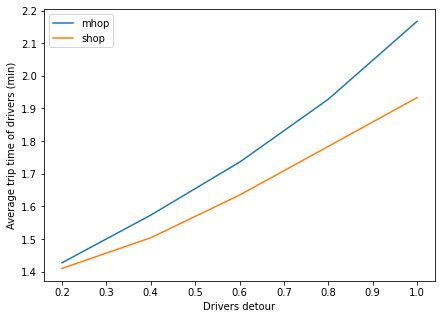

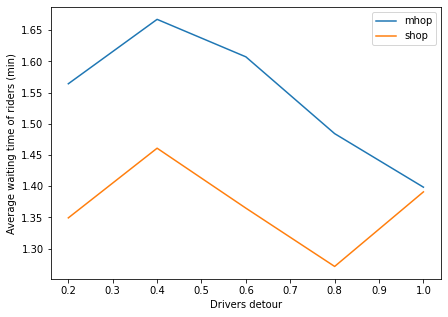

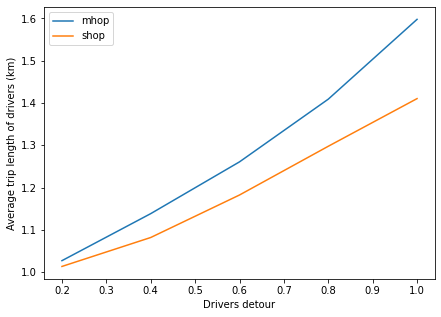

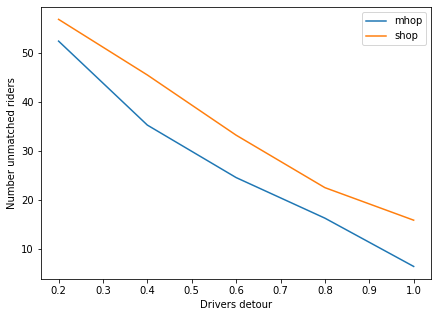

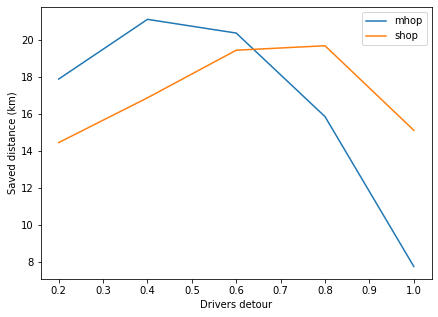

In [59]:
entries = ["Average trip time of drivers (min)", "Average waiting time of riders (min)", 
           "Average trip length of drivers (km)", "Number unmatched riders", "Saved distance (km)"]
DET_FACTOR_D = [0.2,0.4,0.6,0.8,1]
HOP = ['mhop','shop']
for i in range(len(entries)) :
    f = plt.figure(figsize=(7, 5))
    for j in range(len(HOP)):
        avg = [x for x,_ in show_res[j][i]]
        poly_avg = np.polyfit(DET_FACTOR_D,avg,3) 
        poly_y_avg = np.poly1d(poly_avg)(DET_FACTOR_D)
        
        
        #std = [x for _,x in show_res[j][i]]
#         poly_std = np.polyfit(MAX_NB_DRIVERS,std,5) 
#         poly_y_std = np.poly1d(poly_std)(MAX_NB_DRIVERS)
        #plt.plot(DET_FACTOR_D, avg, label = HOP[j])
        plt.plot(DET_FACTOR_D, poly_y_avg, label = HOP[j])
        #plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)

    plt.xlabel('Drivers detour')
    plt.ylabel(entries[i])
    plt.legend()
    
    #entry = entries[i].replace(' ','_').split("(")[0]
    #path = '/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp1/'+entry+'.png'
    #plt.savefig(path,format='png')
    plt.show()

In [ ]:
d_id = 49
print("arr",sma.getAgentFromId(d_id).arr)
print("ddl",sma.getAgentFromId(d_id).ddl)
print("slk",sma.getAgentFromId(d_id).slk)
print("cap",sma.getAgentFromId(d_id).capacities)
print("perc",sma.getAgentFromId(d_id).perceptions)
print("stops",sma.getAgentFromId(d_id).stops)
print("trip",sma.getAgentFromId(d_id).trip)
print("v_r",sma.getAgentFromId(d_id).current_pos)
print("v_arr",sma.getAgentFromId(d_id).v_arr)
sma.getAgentFromId(d_id)

In [ ]:
sma.getAgentFromId(d_id).decide()

In [ ]:
d_id = 20
print("arr",sma.getAgentFromId(d_id).arr)
print("ddl",sma.getAgentFromId(d_id).ddl)
print("slk",sma.getAgentFromId(d_id).slk)
print("cap",sma.getAgentFromId(d_id).capacities)
print("perc",sma.getAgentFromId(d_id).perceptions)
print("stops",sma.getAgentFromId(d_id).stops)
print("trip",sma.getAgentFromId(d_id).trip)
print("v_r",sma.getAgentFromId(d_id).current_pos)
print("v_arr",sma.getAgentFromId(d_id).v_arr)
sma.getAgentFromId(d_id)

In [ ]:
nx.has_path(G,53090940,53027459)

In [ ]:
class SMA:
    def __init__(self, verbose=False, place='Piedmont, California, USA', speed=50, show_graph=False, hop='mhop'):
        self.tick=0 #1 tick = 1 seconde
        self.resetTicks()
        
        if hop in ['mhop','shop','nohop']:
            self.hop = hop
        else :
            raise Exception("hop parameters is either : mhop, shop or nohop")
            
        
        if place=='grid':
            north, south, east, west = 37.79, 37.78, -122.41, -122.43
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            
            
        else:
            gdf = ox.geocode_to_gdf(place) 
            # get the street network within this bounding box
            west, south, east, north = list(gdf.bounds.iloc[0])
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            #self.bbox = (self.min_lon, self.min_lat, self.max_lon, self.max_lat)
            
        self.G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
        
#         #filter deadends
#         deadends = []
#         for node in list(self.G.nodes):
#             if self.G.nodes[node]['street_count']==1:
#                 deadends.append(node)
#         print(deadends)
#         self.G.remove_nodes_from(deadends)
        
        if show_graph:
            fig, ax = ox.plot_graph(self.G, figsize=(20, 20),  node_size=20)
        self.speed = speed
        # hwy_speeds = {'residential': 30,
        #               'secondary': 50,
        #               'tertiary': 70}

        hwy_speeds = {'residential': self.speed,
                      'primary':self.speed,
                      'secondary': self.speed,
                      'tertiary': self.speed,
                      'motorway': self.speed,
                      'trunk': self.speed}

        self.G = ox.add_edge_speeds(self.G, hwy_speeds, precision=0)
        #temps arrondis
        self.G = ox.add_edge_travel_times(self.G, precision=0)
        
        #dictionnaire des agents par type
        self.agentTypeIdDict = {}
        self.agentTypeIdDict["drivers"] = []
        self.agentTypeIdDict["riders"] = []
        self.agentTypeIdDict["tsas"] = []
        self.agentTypeIdDict["tgas"] = []
        
        #dictionnaire des agents par id
        self.agentDict = {}
        
        #arbre d'indexation spatiale R-TREE
        self.rtree = rtree.index.Index()
        
        #self.G = None
        self.verbose = verbose
        
        
        ####DATA####
        self.data = dict()
        self.data['d_trip_time'] = []
        self.data['d_trip_length'] = []
        self.data['r_waiting_time'] = []
        self.data['r_nb_unmatched'] = 0
    
    def resetTicks(self):
        self.tick=0
          
    def setRoadGraph(self,graph):
        self.G = graph
        
    def addAgent(self,ag):
        self.agentDict[ag.unique_id] = ag
        if "RiderAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["riders"].append(ag.unique_id)
        elif "DriverAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["drivers"].append(ag.unique_id)
        elif "TransportServiceAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tsas"].append(ag.unique_id)
        elif "TransportGeneratorAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tgas"].append(ag.unique_id)
        else: raise Exception(ag.__class__.__name__,"is a wrong type of agent.")
            
            
    def getAgentFromId(self, unique_id):
        return self.agentDict[unique_id]
    
    def getRiders(self):
        R = []
        for r in self.agentTypeIdDict['riders']:
            R.append(self.agentDict[r])
        return R
        
    def getDrivers(self):
        D = []
        for d in self.agentTypeIdDict['drivers']:
            D.append(self.agentDict[d])
        return D
        
    def getTSAs(self):
        TSA = []
        for tsa in self.agentTypeIdDict['tsas']:
            TSA.append(self.agentDict[tsa])
        return TSA
    
    def getTGAs(self):
        TGA = []
        for tga in self.agentTypeIdDict['tgas']:
            TGA.append(self.agentDict[tga])
        return TGA

    def run(self,rounds=None):
        if rounds==None:
            #on s'arrete si tout les passagers ou tout les conducteurs sont arrivés
            self.runOnce()
            while len([agent for agent in sma.agentDict.values() if ("RiderAgent" in agent.__class__.__name__)]) > 0 and len([agent for agent in sma.agentDict.values() if ("DriverAgent" in agent.__class__.__name__)]) > 0:
                self.runOnce()
            #print("Finished in",self.tick,"ticks")
        
        else :
            #génération classique
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentDict.values() :
            #print(ag.unique_id)
            ag.update()
            ag.decide()
        
        #phase de nettoyage des agents morts
        for ag in self.agentDict.copy().values():
            if ag.is_alive == False:
                if "RiderAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["riders"].remove(ag.unique_id)
                elif "DriverAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["drivers"].remove(ag.unique_id)
                elif "TransportServiceAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tsas"].remove(ag.unique_id)
                elif "TransportGeneratorAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tgas"].remove(ag.unique_id)
                else: raise Exception(ag.__class__.__name__,"is a wrong type of agent, even if diying.")
                
                self.agentDict.pop(ag.unique_id)
                
                
        if self.verbose == True:      
            print("tick",str(self.tick),"ended")

In [ ]:
a = ['mhop','shop','nohop']
'mhop' in a

In [ ]:
#remplacé par r-tree
class TransportServiceAgent(Agent):
    #tsa : agent blackboard
    def __init__(self, unique_id):
        super().__init__(unique_id)
        self.nodes_to_drivers = dict()
        for node in list(sma.G.nodes):
            self.nodes_to_drivers[node] = set()
        self.drivers_to_nodes = dict()
        
    
     
    def update_driver_data(self, d):
        if d.is_alive == False:
            for node in self.drivers_to_nodes[d]:
                self.nodes_to_drivers[node].remove(d)
            del self.drivers_to_nodes[d]
            
        else :
            node_set = set([item for sublist in d.perceptions for item in sublist])
            #print("node set",node_set)
            #print("d nodes ranges",d.perceptions)
            if d in self.drivers_to_nodes.keys() :
                #noeuds à retirer
                old_nodes = self.drivers_to_nodes[d] - node_set
                #noeuds à ajouter
                new_nodes = node_set - self.drivers_to_nodes[d]

                for old_node in old_nodes:
                    self.nodes_to_drivers[old_node].remove(d)

                for new_node in new_nodes:
                    self.nodes_to_drivers[new_node].add(d)
            else :
                for node in node_set:
                    self.nodes_to_drivers[node].add(d)


            self.drivers_to_nodes[d] = node_set
            
    def get_drivers_from_node(self, node):
        
        return self.nodes_to_drivers[node]
    
    def get_nodes_from_driver(self,driver):
        
        return self.drivers_to_nodes[driver]
    
    def update(self):
        #print("nodes to drivers",self.nodes_to_drivers)
        #print("drivers to nodes",self.drivers_to_nodes)
        pass
    
    def decide(self):
        pass

In [ ]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive') 
fig, ax = ox.plot_graph(G,  figsize=(20, 20),  node_size=70)
hwy_speeds = {'residential': 30,
              'secondary': 50,
              'tertiary': 70}
G = ox.add_edge_speeds(G, hwy_speeds)

#temps arrondis
G = ox.add_edge_travel_times(G, precision=0)

    

In [ ]:
rounds = 10000
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=False)
sma.addAgent(d1)
for _ in range(rounds):
    sma.runOnce()
    #print(sma.rtree)

In [ ]:
rounds = 50
sma = SMA()
sma.setRoadGraph(G)
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
tsa1 = TransportServiceAgent(1)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.1, pref_weight='travel_time',test=True)

sma.addAgent(tsa1)
sma.addAgent(d1)

sma.runOnce()
nc = ['b' if (v in d1.get_perception_set_node()) else 'w' for v in sma.G.nodes()]

fig, ax = ox.plot_graph(sma.G, figsize=(20, 20), node_color=nc, node_edgecolor='k', node_size=70, 
                           node_zorder=3, edge_color='w', edge_linewidth=1)

In [ ]:
rounds = 50
sma = SMA()
sma.setRoadGraph(G)
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
tsa1 = TransportServiceAgent(1)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.8, pref_weight='travel_time',test=True)

sma.addAgent(tsa1)
sma.addAgent(d1)

nc = ['b' if (v in d1.get_perception_set_node()) else 'w' for v in sma.G.nodes()]

fig, ax = ox.plot_graph(sma.G, figsize=(20, 20), node_color=nc, node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color='w', edge_linewidth=3)

for _ in range(rounds):
    sma.runOnce()
print(d1.get_perception_set_node())
r1, r2 = random.sample(d1.get_perception_set_node(),2)

d1.add_rider_to_scheduler(None,  r1, r2, 60, 100)

for _ in range(10000):
    sma.runOnce()

In [ ]:
# SPL = nx.shortest_path_length(sma.G, orig, dest, weight='length')
# sub_g_orig = ox.truncate.truncate_graph_dist(sma.G, orig, max_dist=SPL/4, weight='length', retain_all=True)
# #fig, ax = ox.plot_graph(sub_g)

# sub_g_dest = ox.truncate.truncate_graph_dist(sma.G, dest, max_dist=SPL/4, weight='length', retain_all=True)
# #fig, ax = ox.plot_graph(sub_g)

# ec = ['b' if ((u,v) in sub_g_orig.edges() or (u,v) in sub_g_dest.edges()) else 'r' for u, v, k in sma.G.edges(keys=True)]

# fig, ax = ox.plot_graph(sma.G, node_color='w', node_edgecolor='k', node_size=30, 
#                            node_zorder=3, edge_color=ec, edge_linewidth=3)

In [ ]:

orig = list(G)[1]
dest = list(G)[120]
weight='travel_time'
SPL = nx.shortest_path_length(sma.G, orig, dest, weight=weight)
coef_det = 0.2
det = SPL + (SPL*coef_det)


def get_perception(self, orig, dest, max_weight):
    visited = []
    perception = []
    current_node = orig
    self.algo_recu(current_node)
    return perception

def algo_recu(self, current_node):
    for succ in G.neighbors(current_node):
        if succ not in visited :
            visited.append(succ)
            try: 
                if nx.shortest_path_length(sma.G, orig, succ, weight=self.pref_weight) + nx.shortest_path_length(sma.G, succ, dest, weight=pref_weight) <= max_weight:
                    perception.append(succ)
                    self.algo_recu(succ)
            except (KeyError, nx.NetworkXNoPath):
                pass
            
        


In [ ]:
nc = ['b' if (v in perception) else 'w' for v in sma.G.nodes()]

fig, ax = ox.plot_graph(sma.G, node_color=nc, node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color='w', edge_linewidth=3)

In [ ]:
routes = ox.k_shortest_paths(G, orig, dest, k=2, weight='length')
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors='y', route_linewidth=4, node_size=0)


In [ ]:
'''Faire ce quil y a au dessus mais pour chaque noeuds composant le shortest trip ? AVEC SLK''' 

In [ ]:
def my_all_paths(G, source, target, weight_name, w):
    cutoff = len(G)-1
    visited = [source]
    stack = [iter(G[source])]
    weight = 0
    while stack:
        children = stack[-1]
        child = next(children, None)
        if child is None:
            stack.pop()
            visited.pop()
        elif len(visited) < cutoff:
            if child == target:
                if (visited[-1],child) in G.edges():
                    temp = G[visited[-1]][child][0][weight_name]
                else:
                    temp = G[child][visited[-1]][0][weight_name]
                if weight+temp <= w:
                    yield visited + [target]
            elif child not in visited:
                if (visited[-1],child) in G.edges():
                    weight += G[visited[-1]][child][0][weight_name]
                else:
                    weight += G[child][visited[-1]][0][weight_name]
                visited.append(child)
                stack.append(iter(G[child]))
        else: 
            if child == target or target in children:
                if (visited[-1],child) in G.edges():
                    temp = G[visited[-1]][child][0][weight_name]
                else:
                    temp = G[child][visited[-1]][0][weight_name]
                if weight+temp <= w:
                    yield visited + [target]
            stack.pop()
            visited.pop()

In [ ]:
def get_perception(G, source, target, weight_name, w):
    SPL = nx.shortest_path_length(G, source, target,  weight='length'))

In [ ]:
SP =  nx.shortest_path_length(sma.G, orig, dest, weight='length')
paths = list(nx.all_simple_paths(sma.G, orig, dest, cutoff=10))
#paths = list(my_all_paths(sma.G, source=orig, target=dest, weight_name='length', w=10))
        #return set([item for sublist in paths for item in sublist])

In [ ]:
a = nx.johnson(sma.G, weight='length')
a[0]

In [ ]:
len(G.nodes())

In [ ]:
sma.addAgent(d1)
for _ in range(rounds):
    sma.runOnce()